In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from astropy.io import fits
import sys, glob, os
from lmfit import Model, Parameters, report_fit,  minimize
from scipy.interpolate import interp1d
fill_val = 'extrapolate'


In [11]:
def read_HERMES(infile):
    header = fits.getheader(infile)
    bjd = header['MJD-OBS']
    
    if ((header['CTYPE1'] == 'WAVELENGTH') or (header['CTYPE1'] == 'AWAV')):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = crval + np.arange(0, naxis1) * cdelt
    elif (header['CTYPE1'] == 'log(wavelength)'):
        flux = fits.getdata(infile)
        crval = header['CRVAL1']
        cdelt = header['CDELT1']
        naxis1 = header['NAXIS1']
        wave = np.exp(crval + np.arange(0, naxis1)*cdelt)
    else:
        print("Could not read in HERMES fits file - unknown file type.")
        sys.exit()
    
    return wave, flux, bjd

def read_line_list(filename):
    line_centers = []
    line_widths = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            center = float(parts[0])
            width = float(parts[1]) if len(parts) > 1 else 10.0
            line_centers.append(center)
            line_widths.append(width)

    return line_centers, line_widths

def get_all_spectra(folder_path):
    file_paths = glob.glob(os.path.join(folder_path, '*.fits'))
    spectra = [read_HERMES(file) for file in file_paths]
    waves = [s[0] for s in spectra]
    fluxes = [s[1] for s in spectra]
    return waves, fluxes, len(file_paths)


def read_data_and_linelist(folder_path, linelist_file):
    # Read all spectra from the folder
    waves, fluxes, num_epochs = get_all_spectra(folder_path)

    # Read the line centers and widths from the linelist
    line_centers, line_widths = read_line_list(linelist_file)

    return waves, fluxes, line_centers, line_widths, num_epochs

In [13]:
def bestline(rv, line):
    return line - rv * line / (3 * 10**5)

def gauss(x, a, rv, sigma, gamma, line):
    return a * np.exp(-(x - bestline(rv, line))**2 / (2 * sigma**2)) + gamma

def lorentzian(x, a, rv, gamma, gamma_offset, line):
    return a / (1 + ((x - bestline(rv, line)) / gamma)**2) + gamma_offset

In [14]:
def smooth_data(flux, sigma=2):
    return gaussian_filter1d(flux, sigma=sigma)

def find_peaks_and_exclude_regions(wave, flux, prominence=0.1):
    smoothed_flux = smooth_data(flux)
    peaks, _ = find_peaks(smoothed_flux, prominence=prominence)

    if len(peaks) > 0:
        min_index = np.min(peaks)
        max_index = np.max(peaks)
        exclude_mask = (wave >= wave[min_index]) & (wave <= wave[max_index])
        include_mask = ~exclude_mask
        wave_filtered = wave[include_mask]
        flux_filtered = flux[include_mask]
    else:
        wave_filtered = wave
        flux_filtered = flux

    return wave_filtered, flux_filtered, smoothed_flux, peaks

def objective_gauss_multiple_lines_epochs(params, wave_filtered_all, flux_filtered_all, line_centers):
    residuals = []
    
    num_lines = len(line_centers)
    for i in range(len(wave_filtered_all[0])):  # Loop through epochs
        for j in range(num_lines):  # Loop through lines
            a = params[f'a_{j}_{i}']
            sigma = params[f'sigma_{j}_{i}']
            gamma = params[f'gamma_{j}_{i}']
            rv = params[f'rv_{i}']  # Same RV for all lines in the same epoch

            # Model for each line in each epoch
            model = gauss(wave_filtered_all[j][i], a, rv, sigma, gamma, line_centers[j])
            
            # Append residuals
            residuals.extend(model - flux_filtered_all[j][i])
    
    return np.array(residuals)

In [15]:
def fit_rv_multiple_epochs(waves, fluxes, line_centers, line_widths, num_epochs):
    # Prepare to store filtered data
    wave_filtered_all = {i: [] for i in range(len(line_centers))}
    flux_filtered_all = {i: [] for i in range(len(line_centers))}

    # Filter the data for each line and each epoch
    for i in range(num_epochs):
        for j, (center, width) in enumerate(zip(line_centers, line_widths)):
            mask = (waves[i] >= center - width) & (waves[i] <= center + width)
            wave_line = waves[i][mask]
            flux_line = fluxes[i][mask]
            wave_filtered, flux_filtered, _, _ = find_peaks_and_exclude_regions(wave_line, flux_line)
            wave_filtered_all[j].append(wave_filtered)
            flux_filtered_all[j].append(flux_filtered)

    # Initialize lmfit parameters
    params = Parameters()
    num_lines = len(line_centers)
    for i in range(num_epochs):
        for j in range(num_lines):
            params.add(f'a_{j}_{i}', value=1, min=0)
            params.add(f'sigma_{j}_{i}', value=1, min=0)
            params.add(f'gamma_{j}_{i}', value=0)
        params.add(f'rv_{i}', value=0, min=-300, max=300)  # Allow RV to vary per epoch

    # Minimize the objective function
    result = minimize(objective_gauss_multiple_lines_epochs, params, 
                      args=(wave_filtered_all, flux_filtered_all, line_centers))

    # Extract RVs and errors
    rv_results = [result.params[f'rv_{i}'].value for i in range(num_epochs)]
    rv_errors = [result.params[f'rv_{i}'].stderr for i in range(num_epochs)]

    return rv_results, rv_errors, result, wave_filtered_all, flux_filtered_all

In [23]:
def plot_fits(num_epochs, num_lines, result, wave_filtered_all, flux_filtered_all, line_centers):
    fig, axes = plt.subplots(num_epochs, num_lines, figsize=(3 * num_lines, 2 * num_epochs))

    for i in range(num_epochs):
        for j in range(num_lines):
            # Generate fitted curves
            fitted_line = gauss(wave_filtered_all[j][i], 
                                result.params[f'a_{j}_{i}'].value, 
                                result.params[f'rv_{i}'].value, 
                                result.params[f'sigma_{j}_{i}'].value, 
                                result.params[f'gamma_{j}_{i}'].value, 
                                line_centers[j])

            # Select the correct subplot based on the epoch and line index
            ax = axes[i, j] if num_epochs > 1 else axes[j]  # Handle case with single epoch

            # Plot the data and the fitted line
            ax.plot(wave_filtered_all[j][i], flux_filtered_all[j][i], label=f'Data (Line {line_centers[j]:.2f})', color='black')
            ax.plot(wave_filtered_all[j][i], fitted_line, label=f'Gaussian Fit (Line {line_centers[j]:.2f})', color='red')

            # Set labels and titles
            ax.set_xlabel('Wavelength (Angstrom)')
            ax.set_ylabel('Flux')
            ax.set_title(f'Epoch {i+1} - Line {line_centers[j]:.2f}')
            ax.legend()

    # Adjust layout to prevent overlapping plots
    plt.tight_layout()
    plt.show()

### fitting spectra

In [24]:
folder_path = '/home/c4011027/PhD_stuff/be_paper/hermes_data/25_ori'
linelist_file = '/home/c4011027/PhD_stuff/be_paper/hermes_data/emission_linelist.txt'

waves, fluxes, line_centers, line_widths, num_epochs = read_data_and_linelist(folder_path, linelist_file)
rv_results, rv_errors, result, wave_filtered_all, flux_filtered_all = fit_rv_multiple_epochs(waves, fluxes, line_centers, line_widths, num_epochs)

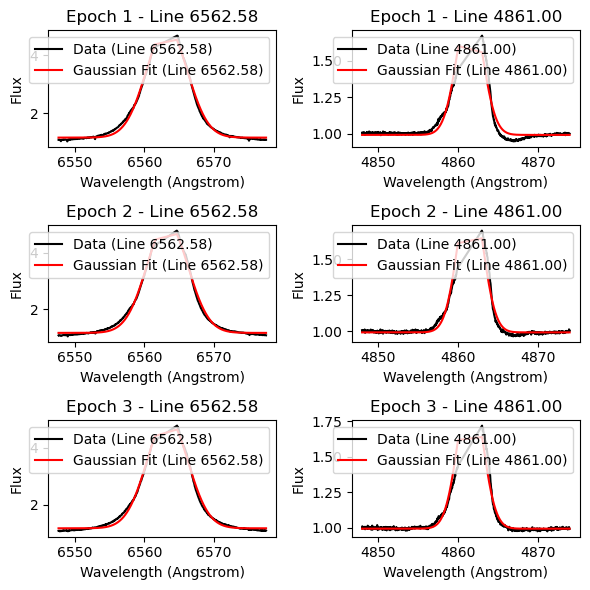

Epoch 1: RV = -30.01 ± 0.24 km/s
Epoch 2: RV = -33.72 ± 0.24 km/s
Epoch 3: RV = -34.22 ± 0.24 km/s


In [25]:
plot_fits(num_epochs, len(line_centers), result, wave_filtered_all, flux_filtered_all, line_centers)

for i, (rv, err) in enumerate(zip(rv_results, rv_errors)):
    print(f"Epoch {i+1}: RV = {rv:.2f} ± {err:.2f} km/s")